# Part 0. Assignment Description

This assignment is about attention and transformer models for language traslation. The main code structure is set up by instructors, while I implmented some core functions. Those are:
* Part 1: class MyGRUCell
* Part 2: class RNNAttentionDecoder
* Part 3: 
    * class ScaledDotAttention
    * class CausalScaledDotAttention

# Colab FAQ

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the colab GPU for this assignmentby selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Setup PyTorch
All files are stored at /content/csc421/a3/ folder


In [0]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install torch torchvision
!pip install Pillow==4.0.0
%mkdir -p /content/csc421/a3/
%cd /content/csc421/a3

     |████████████████████████████████| 5.6MB 2.6MB/s 
     |████████████████████████████████| 112kB 44.1MB/s 
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35417 sha256=dcfc41171b5150802ee8bc9ef1b3eacb6609546d952bb04439d4ec267082114f
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built olefile
ERROR: torchvision 0.5.0 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


/content/csc421/a3


# Helper code

## Utility functions

In [0]:
import os
import pdb
import argparse
import pickle as pkl

from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from six.moves.urllib.request import urlretrieve
import tarfile
import pickle
import sys


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
def to_var(tensor, cuda):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

        Arguments:
            tensor: A Tensor object.
            cuda: A boolean flag indicating whether to use the GPU.

        Returns:
            A Variable object, on the GPU if cuda==True.
    """
    if cuda:
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


def create_dir_if_not_exists(directory):
    """Creates a directory if it doesn't already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)


def save_loss_plot(train_losses, val_losses, opts):
    """Saves a plot of the training and validation loss curves.
    """
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(val_losses)), val_losses)
    plt.title('BS={}, nhid={}'.format(opts.batch_size, opts.hidden_size), fontsize=20)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(opts.checkpoint_path, 'loss_plot.pdf'))
    plt.close()


def checkpoint(encoder, decoder, idx_dict, opts):
    """Saves the current encoder and decoder models, along with idx_dict, which
    contains the char_to_index and index_to_char mappings, and the start_token
    and end_token values.
    """
    with open(os.path.join(opts.checkpoint_path, 'encoder.pt'), 'wb') as f:
        torch.save(encoder, f)

    with open(os.path.join(opts.checkpoint_path, 'decoder.pt'), 'wb') as f:
        torch.save(decoder, f)

    with open(os.path.join(opts.checkpoint_path, 'idx_dict.pkl'), 'wb') as f:
        pkl.dump(idx_dict, f)


## Data loader

In [0]:
def read_lines(filename):
    """Read a file and split it into lines.
    """
    lines = open(filename).read().strip().lower().split('\n')
    return lines


def read_pairs(filename):
    """Reads lines that consist of two words, separated by a space.

    Returns:
        source_words: A list of the first word in each line of the file.
        target_words: A list of the second word in each line of the file.
    """
    lines = read_lines(filename)
    source_words, target_words = [], []
    for line in lines:
        line = line.strip()
        if line:
            source, target = line.split()
            source_words.append(source)
            target_words.append(target)
    return source_words, target_words


def all_alpha_or_dash(s):
    """Helper function to check whether a string is alphabetic, allowing dashes '-'.
    """
    return all(c.isalpha() or c == '-' for c in s)


def filter_lines(lines):
    """Filters lines to consist of only alphabetic characters or dashes "-".
    """
    return [line for line in lines if all_alpha_or_dash(line)]


def load_data():
    """Loads (English, Pig-Latin) word pairs, and creates mappings from characters to indexes.
    """

    source_lines, target_lines = read_pairs('data/pig_latin_data.txt')

    # Filter lines
    source_lines = filter_lines(source_lines)
    target_lines = filter_lines(target_lines)

    all_characters = set(''.join(source_lines)) | set(''.join(target_lines))

    # Create a dictionary mapping each character to a unique index
    char_to_index = { char: index for (index, char) in enumerate(sorted(list(all_characters))) }

    # Add start and end tokens to the dictionary
    start_token = len(char_to_index)
    end_token = len(char_to_index) + 1
    char_to_index['SOS'] = start_token
    char_to_index['EOS'] = end_token

    # Create the inverse mapping, from indexes to characters (used to decode the model's predictions)
    index_to_char = { index: char for (char, index) in char_to_index.items() }

    # Store the final size of the vocabulary
    vocab_size = len(char_to_index)

    line_pairs = list(set(zip(source_lines, target_lines)))  # Python 3

    idx_dict = { 'char_to_index': char_to_index,
                 'index_to_char': index_to_char,
                 'start_token': start_token,
                 'end_token': end_token }

    return line_pairs, vocab_size, idx_dict


def create_dict(pairs):
    """Creates a mapping { (source_length, target_length): [list of (source, target) pairs]
    This is used to make batches: each batch consists of two parallel tensors, one containing
    all source indexes and the other containing all corresponding target indexes.
    Within a batch, all the source words are the same length, and all the target words are
    the same length.
    """
    unique_pairs = list(set(pairs))  # Find all unique (source, target) pairs

    d = defaultdict(list)
    for (s,t) in unique_pairs:
        d[(len(s), len(t))].append((s,t))

    return d


## Training and evaluation code

In [0]:
def string_to_index_list(s, char_to_index, end_token):
    """Converts a sentence into a list of indexes (for each character).
    """
    return [char_to_index[char] for char in s] + [end_token]  # Adds the end token to each index list


def translate_sentence(sentence, encoder, decoder, idx_dict, opts):
    """Translates a sentence from English to Pig-Latin, by splitting the sentence into
    words (whitespace-separated), running the encoder-decoder model to translate each
    word independently, and then stitching the words back together with spaces between them.
    """
    if idx_dict is None:
      line_pairs, vocab_size, idx_dict = load_data()
    return ' '.join([translate(word, encoder, decoder, idx_dict, opts) for word in sentence.split()])


def translate(input_string, encoder, decoder, idx_dict, opts):
    """Translates a given string from English to Pig-Latin.
    """

    char_to_index = idx_dict['char_to_index']
    index_to_char = idx_dict['index_to_char']
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']

    max_generated_chars = 20
    gen_string = ''

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(torch.LongTensor(indexes).unsqueeze(0), opts.cuda)  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_last_hidden = encoder(indexes)

    decoder_hidden = encoder_last_hidden
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    for i in range(max_generated_chars):
      ## slow decoding, recompute everything at each time
      decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden)
      generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
      ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
      ni = ni[-1] #latest output token

      decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)
      
      if ni == end_token:
          break
      else:
          gen_string = "".join(
              [index_to_char[int(item)] 
               for item in generated_words.cpu().numpy().reshape(-1)])

    return gen_string


def visualize_attention(input_string, encoder, decoder, idx_dict, opts):
    """Generates a heatmap to show where attention is focused in each decoder step.
    """
    if idx_dict is None:
      line_pairs, vocab_size, idx_dict = load_data()
    char_to_index = idx_dict['char_to_index']
    index_to_char = idx_dict['index_to_char']
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']

    max_generated_chars = 20
    gen_string = ''

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(torch.LongTensor(indexes).unsqueeze(0), opts.cuda)  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_hidden = encoder(indexes)

    decoder_hidden = encoder_hidden
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    produced_end_token = False

    for i in range(max_generated_chars):
      ## slow decoding, recompute everything at each time
      decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden)
      generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
      ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
      ni = ni[-1] #latest output token
      
      decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)
      
      if ni == end_token:
          break
      else:
          gen_string = "".join(
              [index_to_char[int(item)] 
               for item in generated_words.cpu().numpy().reshape(-1)])
    
    if isinstance(attention_weights, tuple):
      ## transformer's attention mweights
      attention_weights, self_attention_weights = attention_weights
    
    all_attention_weights = attention_weights.data.cpu().numpy()
    
    for i in range(len(all_attention_weights)):
      attention_weights_matrix = all_attention_weights[i].squeeze()
      fig = plt.figure()
      ax = fig.add_subplot(111)
      cax = ax.matshow(attention_weights_matrix, cmap='bone')
      fig.colorbar(cax)

      # Set up axes
      ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
      ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))

      # Show label at every tick
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
      ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
      # Add title
      plt.xlabel('Attention weights to the source sentence in layer {}'.format(i+1))
      plt.tight_layout()
      plt.grid('off')
      plt.show()
      #plt.savefig(save)

      #plt.close(fig)

    return gen_string


def compute_loss(data_dict, encoder, decoder, idx_dict, criterion, optimizer, opts):
    """Train/Evaluate the model on a dataset.

    Arguments:
        data_dict: The validation/test word pairs, organized by source and target lengths.
        encoder: An encoder model to produce annotations for each step of the input sequence.
        decoder: A decoder model (with or without attention) to generate output tokens.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Train the weights if an optimizer is given. None if only evaluate the model. 
        opts: The command-line arguments.

    Returns:
        mean_loss: The average loss over all batches from data_dict.
    """
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    losses = []
    for key in data_dict:
        input_strings, target_strings = zip(*data_dict[key])
        input_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in input_strings]
        target_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in target_strings]

        num_tensors = len(input_tensors)
        num_batches = int(np.ceil(num_tensors / float(opts.batch_size)))

        for i in range(num_batches):

            start = i * opts.batch_size
            end = start + opts.batch_size

            inputs = to_var(torch.stack(input_tensors[start:end]), opts.cuda)
            targets = to_var(torch.stack(target_tensors[start:end]), opts.cuda)

            # The batch size may be different in each epoch
            BS = inputs.size(0)

            encoder_annotations, encoder_hidden = encoder(inputs)

            # The last hidden state of the encoder becomes the first hidden state of the decoder
            decoder_hidden = encoder_hidden

            start_vector = torch.ones(BS).long().unsqueeze(1) * start_token  # BS x 1 --> 16x1  CHECKED
            decoder_input = to_var(start_vector, opts.cuda)  # BS x 1 --> 16x1  CHECKED

            loss = 0.0

            seq_len = targets.size(1)  # Gets seq_len from BS x seq_len

            decoder_inputs = torch.cat([decoder_input, targets[:, 0:-1]], dim=1)  # Gets decoder inputs by shifting the targets to the right 
            
            decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, encoder_hidden)
            decoder_outputs_flatten = decoder_outputs.view(-1, decoder_outputs.size(2))
            targets_flatten = targets.view(-1)
            loss = criterion(decoder_outputs_flatten, targets_flatten)

            losses.append(loss.item())

            ## training if an optimizer is provided
            if optimizer:
              # Zero gradients
              optimizer.zero_grad()
              # Compute gradients
              loss.backward()
              # Update the parameters of the encoder and decoder
              optimizer.step()
              
    mean_loss = np.mean(losses)
    return mean_loss

  

def training_loop(train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts):
    """Runs the main training loop; evaluates the model on the val set every epoch.
        * Prints training and val loss each epoch.
        * Prints qualitative translation results each epoch using TEST_SENTENCE
        * Saves an attention map for TEST_WORD_ATTN each epoch

    Arguments:
        train_dict: The training word pairs, organized by source and target lengths.
        val_dict: The validation word pairs, organized by source and target lengths.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        encoder: An encoder model to produce annotations for each step of the input sequence.
        decoder: A decoder model (with or without attention) to generate output tokens.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Implements a step rule to update the parameters of the encoder and decoder.
        opts: The command-line arguments.
    """

    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    loss_log = open(os.path.join(opts.checkpoint_path, 'loss_log.txt'), 'w')

    best_val_loss = 1e6
    train_losses = []
    val_losses = []

    for epoch in range(opts.nepochs):

        optimizer.param_groups[0]['lr'] *= opts.lr_decay
        
        train_loss = compute_loss(train_dict, encoder, decoder, idx_dict, criterion, optimizer, opts)
        val_loss = compute_loss(val_dict, encoder, decoder, idx_dict, criterion, None, opts)

        if val_loss < best_val_loss:
            checkpoint(encoder, decoder, idx_dict, opts)

        gen_string = translate_sentence(TEST_SENTENCE, encoder, decoder, idx_dict, opts)
        print("Epoch: {:3d} | Train loss: {:.3f} | Val loss: {:.3f} | Gen: {:20s}".format(epoch, train_loss, val_loss, gen_string))

        loss_log.write('{} {} {}\n'.format(epoch, train_loss, val_loss))
        loss_log.flush()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        save_loss_plot(train_losses, val_losses, opts)


def print_data_stats(line_pairs, vocab_size, idx_dict):
    """Prints example word pairs, the number of data points, and the vocabulary.
    """
    print('=' * 80)
    print('Data Stats'.center(80))
    print('-' * 80)
    for pair in line_pairs[:5]:
        print(pair)
    print('Num unique word pairs: {}'.format(len(line_pairs)))
    print('Vocabulary: {}'.format(idx_dict['char_to_index'].keys()))
    print('Vocab size: {}'.format(vocab_size))
    print('=' * 80)


def train(opts):
    line_pairs, vocab_size, idx_dict = load_data()
    print_data_stats(line_pairs, vocab_size, idx_dict)

    # Split the line pairs into an 80% train and 20% val split
    num_lines = len(line_pairs)
    num_train = int(0.8 * num_lines)
    train_pairs, val_pairs = line_pairs[:num_train], line_pairs[num_train:]

    # Group the data by the lengths of the source and target words, to form batches
    train_dict = create_dict(train_pairs)
    val_dict = create_dict(val_pairs)

    ##########################################################################
    ### Setup: Create Encoder, Decoder, Learning Criterion, and Optimizers ###
    ##########################################################################
    if opts.encoder_type == "rnn":
      encoder = GRUEncoder(vocab_size=vocab_size, 
                          hidden_size=opts.hidden_size, 
                          opts=opts)
    elif opts.encoder_type == "transformer":
      encoder = TransformerEncoder(vocab_size=vocab_size, 
                                   hidden_size=opts.hidden_size, 
                                   num_layers=opts.num_transformer_layers,
                                   opts=opts)
    else:
        raise NotImplementedError

    if opts.decoder_type == 'rnn':
        decoder = RNNDecoder(vocab_size=vocab_size, 
                             hidden_size=opts.hidden_size)
    elif opts.decoder_type == 'rnn_attention':
        decoder = RNNAttentionDecoder(vocab_size=vocab_size, 
                                      hidden_size=opts.hidden_size, 
                                      attention_type=opts.attention_type)
    elif opts.decoder_type == 'transformer':
        decoder = TransformerDecoder(vocab_size=vocab_size, 
                                     hidden_size=opts.hidden_size, 
                                     num_layers=opts.num_transformer_layers)
    else:
        raise NotImplementedError
        
    #### setup checkpoint path
    model_name = 'h{}-bs{}-{}'.format(opts.hidden_size, 
                                      opts.batch_size, 
                                      opts.decoder_type)
    opts.checkpoint_path = model_name
    create_dir_if_not_exists(opts.checkpoint_path)
    ####

    if opts.cuda:
        encoder.cuda()
        decoder.cuda()
        print("Moved models to GPU!")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=opts.learning_rate)

    try:
        training_loop(train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts)
    except KeyboardInterrupt:
        print('Exiting early from training.')
        return encoder, decoder
      
    return encoder, decoder


def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)


## Download dataset

In [0]:
######################################################################
# Download Translation datasets
######################################################################
data_fpath = get_file(fname='pig_latin_data.txt', 
                         origin='http://www.cs.toronto.edu/~jba/pig_latin_data.txt', 
                         untar=False)

data/pig_latin_data.txt


# Part 1: Gated Recurrent Unit (GRU

## Step 1: GRU Cell
Please implement the Gated Recurent Unit class defined in the next cell. 

In [0]:
class MyGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyGRUCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # ------------
        # FILL THIS IN
        # ------------
        ## Input linear layers
        self.Wiz = nn.Linear(input_size, hidden_size, bias=False)
        self.Wir = nn.Linear(input_size, hidden_size, bias=False)
        self.Wih = nn.Linear(input_size, hidden_size, bias=False)

        ## Hidden linear layers
        self.Whz = nn.Linear(hidden_size, hidden_size, bias=True)
        self.Whr = nn.Linear(hidden_size, hidden_size, bias=True)
        self.Whh = nn.Linear(hidden_size, hidden_size, bias=True)
        

    def forward(self, x, h_prev):
        """Forward pass of the GRU computation for one time step.

        Arguments
            x: batch_size x input_size
            h_prev: batch_size x hidden_size

        Returns:
            h_new: batch_size x hidden_size
        """

        # ------------
        # FILL THIS IN
        # ------------
        sigmoid_op = nn.Sigmoid()
        tanh_op = nn.Tanh()
        z = sigmoid_op(self.Wiz(x) + self.Whz(h_prev))
        r = sigmoid_op(self.Wir(x) + self.Whr(h_prev))
        g = tanh_op(self.Wih(x) + self.Whh(h_prev))
        h_new = torch.mul(1-z, g) + torch.mul(z, h_prev)
        return h_new

        

## Step 2: GRU Encoder
Please inspect the following recurrent encoder/decoder implementations. Make sure to run the cells before proceeding. 

In [0]:
class GRUEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, opts):
        super(GRUEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.opts = opts

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = MyGRUCell(hidden_size, hidden_size)

    def forward(self, inputs):
        """Forward pass of the encoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all time steps in the sequence. (batch_size x seq_len)

        Returns:
            annotations: The hidden states computed at each step of the input sequence. (batch_size x seq_len x hidden_size)
            hidden: The final hidden state of the encoder, for each sequence in a batch. (batch_size x hidden_size)
        """

        batch_size, seq_len = inputs.size()
        hidden = self.init_hidden(batch_size)

        encoded = self.embedding(inputs)  # batch_size x seq_len x hidden_size
        annotations = []

        for i in range(seq_len):
            x = encoded[:,i,:]  # Get the current time step, across the whole batch
            hidden = self.gru(x, hidden)
            annotations.append(hidden)

        annotations = torch.stack(annotations, dim=1)
        return annotations, hidden

    def init_hidden(self, bs):
        """Creates a tensor of zeros to represent the initial hidden states
        of a batch of sequences.

        Arguments:
            bs: The batch size for the initial hidden state.

        Returns:
            hidden: An initial hidden state of all zeros. (batch_size x hidden_size)
        """
        return to_var(torch.zeros(bs, self.hidden_size), self.opts.cuda)

In [0]:
class RNNDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(RNNDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = MyGRUCell(input_size=hidden_size, hidden_size=hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, annotations, hidden_init):
        """Forward pass of the non-attentional decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch. (batch_size x seq_len)
            annotations: This is not used here. It just maintains consistency with the
                    interface used by the AttentionDecoder class.
            hidden_init: The hidden states from the last step of encoder, across a batch. (batch_size x hidden_size)

        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            None        
        """        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size        

        hiddens = []
        h_prev = hidden_init
        for i in range(seq_len):
            x = embed[:,i,:]  # Get the current time step input tokens, across the whole batch
            h_prev = self.rnn(x, h_prev)  # batch_size x hidden_size
            hiddens.append(h_prev)

        hiddens = torch.stack(hiddens, dim=1) # batch_size x seq_len x hidden_size
        
        output = self.out(hiddens)  # batch_size x seq_len x vocab_size
        return output, None  

## Step 3: Training and Analysis
Train the following language model comprised of recurrent encoder and decoders. 

In [0]:
TEST_SENTENCE = 'the air conditioning is working'

args = AttrDict()
args_dict = {
              'cuda':True, 
              'nepochs':100, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':0.005, 
              'lr_decay':0.99,
              'batch_size':64, 
              'hidden_size':20, 
              'encoder_type': 'rnn', # options: rnn / transformer
              'decoder_type': 'rnn', # options: rnn / rnn_attention / transformer
              'attention_type': '',  # options: additive / scaled_dot
}
args.update(args_dict)

print_opts(args)
rnn_encoder, rnn_decoder = train(args)

translated = translate_sentence(TEST_SENTENCE, rnn_encoder, rnn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.005                                  
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 20                                     
                           encoder_type: rnn                                    
                           decoder_type: rnn                                    
                         attention_type:                                        
                            

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   0 | Train loss: 2.303 | Val loss: 2.170 | Gen: ay ay ontay ay otay 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   1 | Train loss: 1.927 | Val loss: 2.027 | Gen: entay ay ongay-ay ay ontay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   2 | Train loss: 1.796 | Val loss: 1.975 | Gen: ay-ay away ongay ingway ontay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   3 | Train loss: 1.695 | Val loss: 1.905 | Gen: eray-ayday away ongay-ayday ingway otingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   4 | Train loss: 1.616 | Val loss: 1.825 | Gen: eray-ayday away ongay-ayday ingway ongay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   5 | Train loss: 1.550 | Val loss: 1.796 | Gen: entay-ayday away ondway ingway ungay-ayday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   6 | Train loss: 1.499 | Val loss: 1.757 | Gen: entay-ayday away onday-ayday ingway onway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   7 | Train loss: 1.451 | Val loss: 1.754 | Gen: eray-atingway away onday-ayday ingway onday-away-ayday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   8 | Train loss: 1.414 | Val loss: 1.710 | Gen: entay-away-ortay-ayd away ondway iway ondway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   9 | Train loss: 1.384 | Val loss: 1.751 | Gen: entay-away-indayday away ondway ingway ondway-away


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  10 | Train loss: 1.360 | Val loss: 1.663 | Gen: etay away-inday-ayday ondingway iway ondingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  11 | Train loss: 1.313 | Val loss: 1.661 | Gen: etay away-ayday ondingway iway ondingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  12 | Train loss: 1.282 | Val loss: 1.663 | Gen: etay away-ayday oningway iway-ayday ongay-ayday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  13 | Train loss: 1.264 | Val loss: 1.691 | Gen: etay away-ayday ondingway iway oughtay-ayday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  14 | Train loss: 1.249 | Val loss: 1.680 | Gen: etay away oningway iway orkway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  15 | Train loss: 1.225 | Val loss: 1.680 | Gen: etay away ongay-ayday iway-ayday orkway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  16 | Train loss: 1.203 | Val loss: 1.652 | Gen: etay away-indway oningway iway omingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  17 | Train loss: 1.185 | Val loss: 1.643 | Gen: etay away ongay-ayday iway orkway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  18 | Train loss: 1.167 | Val loss: 1.626 | Gen: etay away oningray iway orkway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  19 | Train loss: 1.151 | Val loss: 1.598 | Gen: etay away-inday-awlay ongray-away-inday-aw iway-ayday orkway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  20 | Train loss: 1.142 | Val loss: 1.664 | Gen: etay away ongay-ayday iway orkway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  21 | Train loss: 1.151 | Val loss: 1.574 | Gen: etay away-ayday ondingway iway-ayday orkway-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  22 | Train loss: 1.122 | Val loss: 1.567 | Gen: etay-awlay away-ayday ongray-away-intaray- iway-ayday omingray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  23 | Train loss: 1.112 | Val loss: 1.605 | Gen: etay away oningray iway orkway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  24 | Train loss: 1.109 | Val loss: 1.549 | Gen: etay-ayday away-ybay oningray-awlay iway-ayday omingray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  25 | Train loss: 1.096 | Val loss: 1.593 | Gen: eationtay away oningpay-ayday issay orkway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  26 | Train loss: 1.104 | Val loss: 1.557 | Gen: etay away-ayday onindingway issway orkway-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  27 | Train loss: 1.070 | Val loss: 1.514 | Gen: etay away oningpay isway oway-ypay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  28 | Train loss: 1.063 | Val loss: 1.578 | Gen: essay away ongingsway issay orkway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  29 | Train loss: 1.063 | Val loss: 1.510 | Gen: etay-ayday aidway oningray-away-yeay-a issay owaningway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  30 | Train loss: 1.042 | Val loss: 1.536 | Gen: etay-awlay away oningray-awlay iway orkway-ayday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  31 | Train loss: 1.041 | Val loss: 1.587 | Gen: etay aidway oningpay-oronsway issay oirway-away-yeationw


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  32 | Train loss: 1.033 | Val loss: 1.533 | Gen: etay-ayday away oningray-axtay iay-imationway owingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  33 | Train loss: 1.026 | Val loss: 1.566 | Gen: essay aidway oningpay-oronsway issay orkway-inway-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  34 | Train loss: 1.031 | Val loss: 1.649 | Gen: etay away-yearay oniningpay isway owingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  35 | Train loss: 1.040 | Val loss: 1.557 | Gen: etay away onincioningway issay orkway-indway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  36 | Train loss: 1.016 | Val loss: 1.552 | Gen: etay-inway-awlay aidway oningpay-oroningway issay owingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  37 | Train loss: 1.004 | Val loss: 1.557 | Gen: etay aidway onininingsay issay oirway-away-aysday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  38 | Train loss: 1.020 | Val loss: 1.558 | Gen: estay aidway oningpay-oroningnay issway owingray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  39 | Train loss: 1.017 | Val loss: 1.513 | Gen: etay-inway-awlay aidway onincioningway issay owingay-ayday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  40 | Train loss: 0.989 | Val loss: 1.510 | Gen: etay aidway onintingsay issay orkway-awlay-away-ay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  41 | Train loss: 0.987 | Val loss: 1.506 | Gen: etay airway ontingsay issay owingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  42 | Train loss: 0.991 | Val loss: 1.514 | Gen: eshay aidway onkintsay-awlay issay orkway-inway-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  43 | Train loss: 0.992 | Val loss: 1.550 | Gen: etay away-ayday onintingsay issay owingaray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  44 | Train loss: 0.978 | Val loss: 1.550 | Gen: etay airway onintingsay issay owingay-ayday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  45 | Train loss: 0.961 | Val loss: 1.534 | Gen: etay aidway onintingsay issay orkway-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  46 | Train loss: 0.958 | Val loss: 1.456 | Gen: etay airway onincisingpay-ofseda issay owingay-ayday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  47 | Train loss: 0.953 | Val loss: 1.489 | Gen: etay aidway ontingpay issay orkway-aysday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  48 | Train loss: 0.946 | Val loss: 1.480 | Gen: etay aidway onincionatingway issay ovirgay-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  49 | Train loss: 0.947 | Val loss: 1.505 | Gen: ethay airway onincisingpay issay owingay-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  50 | Train loss: 0.952 | Val loss: 1.495 | Gen: etay aidway onincipateway issay orkway-yearay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  51 | Train loss: 0.941 | Val loss: 1.471 | Gen: etay aidway oninioningway issay owindgray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  52 | Train loss: 0.940 | Val loss: 1.480 | Gen: etay aidway onioningsay issay oviway-inway-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  53 | Train loss: 0.937 | Val loss: 1.451 | Gen: etay aidway ontioningway issay owingray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  54 | Train loss: 0.929 | Val loss: 1.427 | Gen: ethay airway onioningray issay owindgray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  55 | Train loss: 0.911 | Val loss: 1.420 | Gen: ehay aidway onioningray isay oviwalway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  56 | Train loss: 0.914 | Val loss: 1.472 | Gen: etay aidway onionsingmay issay ouwingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  57 | Train loss: 0.933 | Val loss: 1.468 | Gen: ethay airway ontimaningway issay owingray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  58 | Train loss: 0.939 | Val loss: 1.427 | Gen: ehay airway oncioningray isay orkway-yearay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  59 | Train loss: 0.918 | Val loss: 1.494 | Gen: ehay aidway onioningsay issway owingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  60 | Train loss: 0.910 | Val loss: 1.454 | Gen: etay airway onionintway-inway-aw issay oviway-inway-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  61 | Train loss: 0.899 | Val loss: 1.464 | Gen: ehay aidway onioningray issay owingray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  62 | Train loss: 0.895 | Val loss: 1.423 | Gen: ethay airway onounintingmay issay orkway-ybay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  63 | Train loss: 0.886 | Val loss: 1.455 | Gen: ehay aidway onciondingway issay oviway-inway-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  64 | Train loss: 0.886 | Val loss: 1.390 | Gen: ehishedway airway ontioningmay issay owingray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  65 | Train loss: 0.878 | Val loss: 1.417 | Gen: ehay aidway onionintingway isay oviway-ybay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  66 | Train loss: 0.879 | Val loss: 1.412 | Gen: ehay airway onionintway-inway-aw issay owingray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  67 | Train loss: 0.888 | Val loss: 1.456 | Gen: ehay aidway oncioningray issay oviwalway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  68 | Train loss: 0.884 | Val loss: 1.437 | Gen: ehay aidway onintingsay issway owningway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  69 | Train loss: 0.886 | Val loss: 1.427 | Gen: ehay airway oniondingsay issay oviwandway-ayeday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  70 | Train loss: 0.875 | Val loss: 1.400 | Gen: ehishedway airway onionintingmay isay oviwangway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  71 | Train loss: 0.864 | Val loss: 1.390 | Gen: ehay airway onioningray issway oviway-ybay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  72 | Train loss: 0.858 | Val loss: 1.412 | Gen: ehay airway onionintway-inway-aw issay oviway-inway-away-ay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  73 | Train loss: 0.853 | Val loss: 1.400 | Gen: ehtay airway oonitingray issay ownidingray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  74 | Train loss: 0.851 | Val loss: 1.385 | Gen: ehay airway ontiomingway issay ovidingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  75 | Train loss: 0.844 | Val loss: 1.406 | Gen: ehingmay airway oncioningray issay ownidingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  76 | Train loss: 0.839 | Val loss: 1.388 | Gen: ehingmay airway onionintmay-inway-aw issway oviwangway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  77 | Train loss: 0.838 | Val loss: 1.419 | Gen: ethay airway oncioningray issay ownidingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  78 | Train loss: 0.837 | Val loss: 1.413 | Gen: ehingmay airway onioningray issay oviway-indeay-axtay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  79 | Train loss: 0.846 | Val loss: 1.407 | Gen: ehingmay airway oncioningpray issay ovidibay-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  80 | Train loss: 0.849 | Val loss: 1.377 | Gen: ethay airway onioningray issway oviwangway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  81 | Train loss: 0.841 | Val loss: 1.349 | Gen: ethay airway oniondingray issay oviwandway-ayedblay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  82 | Train loss: 0.838 | Val loss: 1.362 | Gen: ethay airway onionintingray issay ovidingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  83 | Train loss: 0.833 | Val loss: 1.410 | Gen: etay airway oniontatingway issway oviway-inway-away-ow


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  84 | Train loss: 0.841 | Val loss: 1.414 | Gen: ethay airway oncioningray issay ovidgray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  85 | Train loss: 0.839 | Val loss: 1.401 | Gen: ethay airway oniondingray issay ovidibay-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  86 | Train loss: 0.823 | Val loss: 1.348 | Gen: ethay airway oncioringhay issway ovirway-ayday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  87 | Train loss: 0.814 | Val loss: 1.363 | Gen: ethay airway onouningpray issay ownidgray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  88 | Train loss: 0.811 | Val loss: 1.388 | Gen: ethay airway-ayday oniondingray issay ovirway-inway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  89 | Train loss: 0.810 | Val loss: 1.351 | Gen: ethay airway onioningray-inway-aw issay ovidingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  90 | Train loss: 0.800 | Val loss: 1.343 | Gen: ethay airway onciroughtway issay ovidingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  91 | Train loss: 0.802 | Val loss: 1.402 | Gen: ethay airway oncionatingway issay ownidingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  92 | Train loss: 0.812 | Val loss: 1.351 | Gen: ethay airway onioniringmay issay ovidingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  93 | Train loss: 0.806 | Val loss: 1.300 | Gen: ethay airway oniondingray issway ovidibay-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  94 | Train loss: 0.795 | Val loss: 1.322 | Gen: ethay airway oncioringhay issay ovidway-iveday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  95 | Train loss: 0.794 | Val loss: 1.307 | Gen: ethay airway onciroughay issay ovidabliway-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  96 | Train loss: 0.794 | Val loss: 1.338 | Gen: ethay airway onioningray-inway-aw issay ovidingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  97 | Train loss: 0.792 | Val loss: 1.291 | Gen: ethay airway ondioninghay issway ovidway-ybay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  98 | Train loss: 0.785 | Val loss: 1.319 | Gen: ethay airway onciroughay issay ovidibay-awlay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  99 | Train loss: 0.781 | Val loss: 1.298 | Gen: ethay airway oncioringhay issway ovidway-ybay
source:		the air conditioning is working 
translated:	ethay airway oncioringhay issway ovidway-ybay


Try translating different sentences by changing the variable TEST_SENTENCE. Identify two distinct failure modes and briefly describe them.

In [0]:
TEST_SENTENCE = 'the air conditioning is working'
translated = translate_sentence(TEST_SENTENCE, rnn_encoder, rnn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the air conditioning is working 
translated:	ethay airway oncioringhay issway ovidway-ybay


In [0]:
TEST_SENTENCE = 'my friend travels once a month'
translated = translate_sentence(TEST_SENTENCE, rnn_encoder, rnn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		my friend travels once a month 
translated:	yday ibertay avelthay-awenway onmecay away onthay


# Part 2: Additive Attention

## Step 1: Additive Attention
Already implemented the additive attention mechanism. Write down the mathematical expression for $\tilde{\alpha}_i^{(t)}, \alpha_i^{(t)}, c_t$ as a function of $W_1, W_2, b_1, b_2, Q_t, K_i$. 

In [0]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size):
        super(AdditiveAttention, self).__init__()

        self.hidden_size = hidden_size

        # A two layer fully-connected network
        # hidden_size*2 --> hidden_size, ReLU, hidden_size --> 1
        self.attention_network = nn.Sequential(
                                    nn.Linear(hidden_size*2, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1)
                                 )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, queries, keys, values):
        """The forward pass of the additive attention mechanism.

        Arguments:
            queries: The current decoder hidden state. (batch_size x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x 1 x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The attention_weights must be a softmax weighting over the seq_len annotations.
        """
        batch_size = keys.size(0)
        expanded_queries = queries.view(batch_size, -1, self.hidden_size).expand_as(keys)
        concat_inputs = torch.cat([expanded_queries, keys], dim=2)
        unnormalized_attention = self.attention_network(concat_inputs)
        attention_weights = self.softmax(unnormalized_attention)
        context = torch.bmm(attention_weights.transpose(2,1), values)
        return context, attention_weights
      

## Step 2: RNN Additive Attention Decoder
We will now implement a recurrent decoder that makes use of the additive attention mechanism. Read the description in the assignment worksheet and complete the following implementation. 

In [0]:
class RNNAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, attention_type='scaled_dot'):
        super(RNNAttentionDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.rnn = MyGRUCell(input_size=hidden_size*2, hidden_size=hidden_size)
        if attention_type == 'additive':
          self.attention = AdditiveAttention(hidden_size=hidden_size)
        elif attention_type == 'scaled_dot':
          self.attention = ScaledDotAttention(hidden_size=hidden_size)
        
        self.out = nn.Linear(hidden_size, vocab_size)

        
    def forward(self, inputs, annotations, hidden_init):
        """Forward pass of the attention-based decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
            annotations: The encoder hidden states for each step of the input.
                         sequence. (batch_size x seq_len x hidden_size)
            hidden_init: The final hidden states from the encoder, across a batch. (batch_size x hidden_size)

        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """
        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size        

        hiddens = []
        attentions = []
        h_prev = hidden_init
        for i in range(seq_len):
            # ------------
            # FILL THIS IN - START
            # ------------
            embed_current = embed[:,i,:]  # Get the current time step, across the whole batch
            context, attention_weights = self.attention.forward(h_prev, annotations, annotations) # batch_size x 1 x hidden_size
            context = context.view(batch_size, -1)
            embed_and_context = torch.cat([context, embed_current], dim=1) # batch_size x (2*hidden_size) 
            h_prev = self.rnn(embed_and_context, h_prev)  # batch_size x hidden_size      
            # ------------
            # FILL THIS IN - START
            # ------------     
            
            hiddens.append(h_prev)
            attentions.append(attention_weights)

        hiddens = torch.stack(hiddens, dim=1) # batch_size x seq_len x hidden_size
        attentions = torch.cat(attentions, dim=2) # batch_size x seq_len x seq_len
        
        output = self.out(hiddens)  # batch_size x seq_len x vocab_size
        return output, attentions
        

## Step 3: Training and Analysis
Train the following language model that uses a recurrent encoder, and a recurrent decoder that has an additive attention component. 

In [0]:
TEST_SENTENCE = 'the air conditioning is working'

args = AttrDict()
args_dict = {
              'cuda':True, 
              'nepochs':100, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':0.005, 
              'lr_decay':0.99,
              'batch_size':64, 
              'hidden_size':20, d
              'encoder_type': 'rnn', # options: rnn / transformer
              'decoder_type': 'rnn_attention', # options: rnn / rnn_attention / transformer
              'attention_type': 'additive',  # options: additive / scaled_dot
}
args.update(args_dict)

print_opts(args)
rnn_attn_encoder, rnn_attn_decoder = train(args)

translated = translate_sentence(TEST_SENTENCE, rnn_attn_encoder, rnn_attn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.005                                  
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 20                                     
                           encoder_type: rnn                                    
                           decoder_type: rnn_attention                          
                         attention_type: additive                               
                            

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   0 | Train loss: 2.319 | Val loss: 2.080 | Gen: ay-inay-inay-inay-in ay inlay inay ingay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   1 | Train loss: 1.865 | Val loss: 1.882 | Gen: ay-oreray ay-intingway oninghay intingay oringhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   2 | Train loss: 1.656 | Val loss: 1.739 | Gen: eray aypay ontingorly ingay oringhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   3 | Train loss: 1.466 | Val loss: 1.681 | Gen: etay aypay oniliningway inay orfay-oringway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   4 | Train loss: 1.332 | Val loss: 1.616 | Gen: ethay aypray-iray-inway oonililinioninininin ingay orhioniongway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   5 | Train loss: 1.199 | Val loss: 1.524 | Gen: ethay aypay-ipray-iway olffay-itingingway istay orhingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   6 | Train loss: 1.075 | Val loss: 1.543 | Gen: ehay aypray ondiningway isay orhingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   7 | Train loss: 0.978 | Val loss: 1.436 | Gen: eway airway ontioningway isway orhingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   8 | Train loss: 0.870 | Val loss: 1.399 | Gen: eway aypray onditingcay isway ortuy-ay-ay-ay-ay-ay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   9 | Train loss: 0.817 | Val loss: 1.140 | Gen: ray airway ondifiningway isway orlyvay-olway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  10 | Train loss: 0.741 | Val loss: 1.091 | Gen: eway ay-oray ondininingnay isway orlyvay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  11 | Train loss: 0.644 | Val loss: 1.117 | Gen: eway aypray ondioningnay isway orkblay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  12 | Train loss: 0.644 | Val loss: 1.102 | Gen: eway airway onditinongway isway orloslway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  13 | Train loss: 0.601 | Val loss: 1.409 | Gen: eway aigway onditoningnay-ondway isway orlcay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  14 | Train loss: 0.634 | Val loss: 0.991 | Gen: eway airway onditininingway isway orkinmoway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  15 | Train loss: 0.468 | Val loss: 0.929 | Gen: eway airway onditininongway ispay orkiningway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  16 | Train loss: 0.413 | Val loss: 0.806 | Gen: eway airway onditioningnay isway orkiningway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  17 | Train loss: 0.373 | Val loss: 0.870 | Gen: eway airway onditininingway isway orkiningway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  18 | Train loss: 0.359 | Val loss: 0.779 | Gen: eway airway onditininingnay isway orkinguway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  19 | Train loss: 0.349 | Val loss: 0.815 | Gen: eway airway onditiontaningway isway orkingnay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  20 | Train loss: 0.366 | Val loss: 0.803 | Gen: eway airway onditioningnay isway orkingnay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  21 | Train loss: 0.342 | Val loss: 0.907 | Gen: eway airway onditioniningway isway orkiniwlyway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  22 | Train loss: 0.335 | Val loss: 1.234 | Gen: eway airhay ondditiiningway isway orkkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  23 | Train loss: 0.331 | Val loss: 0.748 | Gen: eway airway onditiningway isway orkeingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  24 | Train loss: 0.270 | Val loss: 0.945 | Gen: eway airhay onditioningnay ispay orkinglay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  25 | Train loss: 0.284 | Val loss: 1.165 | Gen: eeway airray onditioningnay ispay orkefangway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  26 | Train loss: 0.330 | Val loss: 0.912 | Gen: eway airway onditoningway isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  27 | Train loss: 0.270 | Val loss: 0.644 | Gen: eway airway onditioningmay isway orkinglay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  28 | Train loss: 0.218 | Val loss: 0.752 | Gen: eway airway onditioniningway isway orkinglay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  29 | Train loss: 0.216 | Val loss: 0.893 | Gen: eway airhay onditioningnay isway orkinglay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  30 | Train loss: 0.213 | Val loss: 0.584 | Gen: eway airway onditioningmay isway orkinglay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  31 | Train loss: 0.182 | Val loss: 0.842 | Gen: eway airway onditioniningway isway orkinghay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  32 | Train loss: 0.196 | Val loss: 0.639 | Gen: eway airfay onditionintgay isway orkiningway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  33 | Train loss: 0.173 | Val loss: 0.709 | Gen: eway airway onditioningway isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  34 | Train loss: 0.185 | Val loss: 0.743 | Gen: eway airway onditioningnay isway orkingwhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  35 | Train loss: 0.207 | Val loss: 0.655 | Gen: eway airway onditioningnay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  36 | Train loss: 0.172 | Val loss: 0.620 | Gen: eway airway onditionclongay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  37 | Train loss: 0.162 | Val loss: 0.942 | Gen: eway airway onditoningnay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  38 | Train loss: 0.225 | Val loss: 0.788 | Gen: eway airway ondiitoningnay isway orheingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  39 | Train loss: 0.157 | Val loss: 0.692 | Gen: eway airway onditioningcay isway orkingwhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  40 | Train loss: 0.145 | Val loss: 0.578 | Gen: eway airway onditioningcay isway orkingwhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  41 | Train loss: 0.130 | Val loss: 0.699 | Gen: eway airway onditionincktay isway orkingwhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  42 | Train loss: 0.156 | Val loss: 0.582 | Gen: eway airway onditioningcay isway orkingwhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  43 | Train loss: 0.123 | Val loss: 0.708 | Gen: eway airway onditioningmay isway orkingwhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  44 | Train loss: 0.122 | Val loss: 0.576 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  45 | Train loss: 0.114 | Val loss: 0.842 | Gen: eway airway onditioningnay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  46 | Train loss: 0.146 | Val loss: 0.986 | Gen: ewaokay airway onditioniningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  47 | Train loss: 0.161 | Val loss: 0.664 | Gen: eway airway onditioningcay isway orkingglay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  48 | Train loss: 0.137 | Val loss: 0.556 | Gen: eway airhay onditioningcay isfay orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  49 | Train loss: 0.114 | Val loss: 0.602 | Gen: eway airway onditioningcay isway orkingwhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  50 | Train loss: 0.097 | Val loss: 0.525 | Gen: ethay airway onditioningcay isway orkinghay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  51 | Train loss: 0.110 | Val loss: 0.637 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  52 | Train loss: 0.093 | Val loss: 0.535 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  53 | Train loss: 0.070 | Val loss: 0.529 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  54 | Train loss: 0.063 | Val loss: 0.592 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  55 | Train loss: 0.067 | Val loss: 0.540 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  56 | Train loss: 0.062 | Val loss: 0.550 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  57 | Train loss: 0.102 | Val loss: 0.873 | Gen: ethay airway onditioningcay isfay orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  58 | Train loss: 0.151 | Val loss: 1.011 | Gen: etay airlay onditioningay isway orkinghay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  59 | Train loss: 0.232 | Val loss: 0.895 | Gen: okay airhay onditioningcay isflay orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  60 | Train loss: 0.185 | Val loss: 0.678 | Gen: ethay airway onditioningcay isway orkilongway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  61 | Train loss: 0.122 | Val loss: 0.540 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  62 | Train loss: 0.069 | Val loss: 0.492 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  63 | Train loss: 0.059 | Val loss: 0.513 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  64 | Train loss: 0.054 | Val loss: 0.500 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  65 | Train loss: 0.050 | Val loss: 0.497 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  66 | Train loss: 0.047 | Val loss: 0.501 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  67 | Train loss: 0.044 | Val loss: 0.481 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  68 | Train loss: 0.042 | Val loss: 0.567 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  69 | Train loss: 0.043 | Val loss: 0.555 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  70 | Train loss: 0.040 | Val loss: 0.518 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  71 | Train loss: 0.044 | Val loss: 0.584 | Gen: ethay airway onditiioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  72 | Train loss: 0.120 | Val loss: 1.867 | Gen: ethay airway onditoomtcay isway orkinfray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  73 | Train loss: 0.877 | Val loss: 0.878 | Gen: etaha airway onditionintcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  74 | Train loss: 0.228 | Val loss: 0.593 | Gen: ethay airway onditiooningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  75 | Train loss: 0.125 | Val loss: 0.585 | Gen: ethay airway onditiooningcay isway orkingwhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  76 | Train loss: 0.091 | Val loss: 0.489 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  77 | Train loss: 0.065 | Val loss: 0.467 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  78 | Train loss: 0.054 | Val loss: 0.461 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  79 | Train loss: 0.048 | Val loss: 0.463 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  80 | Train loss: 0.044 | Val loss: 0.441 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  81 | Train loss: 0.040 | Val loss: 0.437 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  82 | Train loss: 0.037 | Val loss: 0.425 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  83 | Train loss: 0.036 | Val loss: 0.440 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  84 | Train loss: 0.034 | Val loss: 0.425 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  85 | Train loss: 0.031 | Val loss: 0.439 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  86 | Train loss: 0.030 | Val loss: 0.420 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  87 | Train loss: 0.029 | Val loss: 0.440 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  88 | Train loss: 0.027 | Val loss: 0.440 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  89 | Train loss: 0.026 | Val loss: 0.445 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  90 | Train loss: 0.025 | Val loss: 0.430 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  91 | Train loss: 0.025 | Val loss: 0.444 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  92 | Train loss: 0.023 | Val loss: 0.440 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  93 | Train loss: 0.022 | Val loss: 0.450 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  94 | Train loss: 0.022 | Val loss: 0.466 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  95 | Train loss: 0.061 | Val loss: 1.220 | Gen: ethay airway ondcitiontningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  96 | Train loss: 0.159 | Val loss: 0.596 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  97 | Train loss: 0.074 | Val loss: 0.510 | Gen: ethay airway onditioningmay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  98 | Train loss: 0.045 | Val loss: 0.434 | Gen: ethay airway onditioningcay isway orkingway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  99 | Train loss: 0.034 | Val loss: 0.490 | Gen: ethay airway onditioningcay isway orkingway
source:		the air conditioning is working 
translated:	ethay airway onditioningcay isway orkingway


In [0]:
TEST_SENTENCE = 'the air conditioning is working'
translated = translate_sentence(TEST_SENTENCE, rnn_attn_encoder, rnn_attn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the air conditioning is working 
translated:	ethay airway onditioningcay isway orkingway


# Part 3: Scaled Dot Product Attention

## Step 1: Implement Dot-Product Attention
Implement the scaled dot product attention module described in the assignment worksheet. 

In [0]:
class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=2)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x k)

            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        # FILL THIS IN
        # ------------
        batch_size, seq_len, hid_size = keys.size()
        # print('batch', batch_size)
        # print('seq_len', seq_len)
        # print('hid_size', hid_size)

        if len(queries.size()) == 2:
            queries = torch.unsqueeze(queries, 1)
        q = self.Q(queries)
        dim_q1, dim_q2, dim_q3 = q.size()
        k_size = dim_q2
        # print('k_size', k_size)
        # print('query shape', q.size())

        k = self.K(keys)
        k = k.view(batch_size, hid_size, seq_len)
        # print('key shape', k.size())

        v = self.V(values)

        unnormalized_attention = self.scaling_factor * torch.bmm(q, k)
        attention_weights = self.softmax(unnormalized_attention)

        context = torch.bmm(attention_weights, v)

        dim_aw1, dim_aw2, dim_aw3 = attention_weights.size()
        attention_weights = attention_weights.view(dim_aw1, dim_aw3, dim_aw2)
        # print('attention weights shape', attention_weights.size())
        
        # print('context shape', context.size())

        return context, attention_weights
        

## Step 2: Implement Causal Dot-Product Attention
Now implement the scaled causal dot product described in the assignment worksheet. 

In [0]:
class CausalScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(CausalScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size
        self.neg_inf = torch.tensor(-1e7)

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=2)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x k)

            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        # FILL THIS IN
        # ------------
        
        batch_size, seq_len, hid_size = keys.size()
        # print('batch', batch_size)
        # print('seq_len', seq_len)
        # print('hid_size', hid_size)

        if len(queries.size()) == 2:
            queries = torch.unsqueeze(queries, 1)
        q = self.Q(queries)
        dim_q1, dim_q2, dim_q3 = q.size()
        k_size = dim_q2
        # print('k_size', k_size)
        # print('query shape', q.size())

        k = self.K(keys)
        k = k.view(batch_size, hid_size, seq_len)
        # print('key shape', k.size())

        v = self.V(values)

        unnormalized_attention = self.scaling_factor * torch.bmm(q, k)
        unnormalized_attention = unnormalized_attention + torch.triu(self.neg_inf.expand_as(unnormalized_attention), diagonal=1)

        attention_weights = self.softmax(unnormalized_attention)

        context = torch.bmm(attention_weights, v)

        dim_aw1, dim_aw2, dim_aw3 = attention_weights.size()
        attention_weights = attention_weights.view(dim_aw1, dim_aw3, dim_aw2)
        # print('attention weights shape', attention_weights.size())
        
        # print('context shape', context.size())
        return context, attention_weights

## Step 3: Transformer Encoder
Complete the following transformer encoder implementation. 

In [0]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, opts):
        super(TransformerEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.opts = opts

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        
        # IMPORTANT CORRECTION: NON-CAUSAL ATTENTION SHOULD HAVE BEEN
        # USED IN THE TRANSFORMER ENCODER. 
        # NEW VERSION: 
        self.self_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size, 
                                 ) for i in range(self.num_layers)])
        # PREVIONS VERSION: 
        # self.self_attentions = nn.ModuleList([CausalScaledDotAttention(
        #                             hidden_size=hidden_size, 
        #                          ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])

        self.positional_encodings = self.create_positional_encodings()

    def forward(self, inputs):
        """Forward pass of the encoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all time steps in the sequence. (batch_size x seq_len)

        Returns:
            annotations: The hidden states computed at each step of the input sequence. (batch_size x seq_len x hidden_size)
            hidden: The final hidden state of the encoder, for each sequence in a batch. (batch_size x hidden_size)
        """

        batch_size, seq_len = inputs.size()
        # ------------
        # FILL THIS IN - START
        # ------------
        encoded = self.embedding(inputs)  # batch_size x seq_len x hidden_size

        # Add positinal embeddings from self.create_positional_encodings. (a'la https://arxiv.org/pdf/1706.03762.pdf, section 3.5)
        
        encoded = encoded + self.positional_encodings[:seq_len]

        annotations = encoded

        for i in range(self.num_layers):
          new_annotations, self_attention_weights = self.self_attentions[i](annotations, annotations, annotations)  # batch_size x seq_len x hidden_size
          residual_annotations = annotations + new_annotations
          new_annotations = self.attention_mlps[i](residual_annotations)
          annotations = residual_annotations + new_annotations
        # ------------
        # FILL THIS IN - END
        # ------------

        # Transformer encoder does not have a last hidden layer. 
        return annotations, None  

    def create_positional_encodings(self, max_seq_len=1000):
      """Creates positional encodings for the inputs.

      Arguments:
          max_seq_len: a number larger than the maximum string length we expect to encounter during training

      Returns:
          pos_encodings: (max_seq_len, hidden_dim) Positional encodings for a sequence with length max_seq_len. 
      """
      pos_indices = torch.arange(max_seq_len)[..., None]
      dim_indices = torch.arange(self.hidden_size//2)[None, ...]
      exponents = (2*dim_indices).float()/(self.hidden_size)
      trig_args = pos_indices / (10000**exponents)
      sin_terms = torch.sin(trig_args)
      cos_terms = torch.cos(trig_args)

      pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
      pos_encodings[:, 0::2] = sin_terms
      pos_encodings[:, 1::2] = cos_terms

      if self.opts.cuda:
        pos_encodings = pos_encodings.cuda()

      return pos_encodings



## Step 4: Transformer Decoder
Complete the following transformer decoder implementation. 

In [0]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)        
        self.num_layers = num_layers
        
        self.self_attentions = nn.ModuleList([CausalScaledDotAttention(
                                    hidden_size=hidden_size, 
                                 ) for i in range(self.num_layers)])
        self.encoder_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size, 
                                 ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])
        self.out = nn.Linear(hidden_size, vocab_size)

        self.positional_encodings = self.create_positional_encodings()

    def forward(self, inputs, annotations, hidden_init):
        """Forward pass of the attention-based decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
            annotations: The encoder hidden states for each step of the input.
                         sequence. (batch_size x seq_len x hidden_size)
            hidden_init: Not used in the transformer decoder
        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """
        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size 

        # THIS LINE WAS ADDED AS A CORRECTION. 
        embed = embed + self.positional_encodings[:seq_len]       

        encoder_attention_weights_list = []
        self_attention_weights_list = []
        contexts = embed
        for i in range(self.num_layers):
          # ------------
          # FILL THIS IN - START
          # ------------
          new_contexts, self_attention_weights =  self.self_attentions[i](contexts, contexts, contexts) # batch_size x seq_len x hidden_size
          residual_contexts = contexts + new_contexts
          new_contexts, encoder_attention_weights = self.encoder_attentions[i](residual_contexts, annotations, annotations) # batch_size x seq_len x hidden_size
          residual_contexts = residual_contexts + new_contexts
          new_contexts = self.attention_mlps[i](residual_contexts)
          contexts = residual_contexts + new_contexts

          # ------------
          # FILL THIS IN - END
          # ------------
          
          encoder_attention_weights_list.append(encoder_attention_weights)
          self_attention_weights_list.append(self_attention_weights)
          
        output = self.out(contexts)
        encoder_attention_weights = torch.stack(encoder_attention_weights_list)
        self_attention_weights = torch.stack(self_attention_weights_list)
        
        return output, (encoder_attention_weights, self_attention_weights)

    def create_positional_encodings(self, max_seq_len=1000):
      """Creates positional encodings for the inputs.

      Arguments:
          max_seq_len: a number larger than the maximum string length we expect to encounter during training

      Returns:
          pos_encodings: (max_seq_len, hidden_dim) Positional encodings for a sequence with length max_seq_len. 
      """
      pos_indices = torch.arange(max_seq_len)[..., None]
      dim_indices = torch.arange(self.hidden_size//2)[None, ...]
      exponents = (2*dim_indices).float()/(self.hidden_size)
      trig_args = pos_indices / (10000**exponents)
      sin_terms = torch.sin(trig_args)
      cos_terms = torch.cos(trig_args)

      pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
      pos_encodings[:, 0::2] = sin_terms
      pos_encodings[:, 1::2] = cos_terms

      pos_encodings = pos_encodings.cuda()

      return pos_encodings


## Step 5: Training and analysis
Now, train the following language model that's comprised of a (simplified) transformer encoder and transformer decoder. 

In [0]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [0]:
TEST_SENTENCE = 'the air conditioning is working'

args = AttrDict()
args_dict = {
              'cuda':True, 
              'nepochs':100, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':0.005,  ## INCREASE BY AN ORDER OF MAGNITUDE
              'lr_decay':0.99,
              'batch_size':64, 
              'hidden_size':20, 
              'encoder_type': 'transformer',
              'decoder_type': 'transformer', # options: rnn / rnn_attention / transformer
              'num_transformer_layers': 3,
}
args.update(args_dict)

print_opts(args)
transformer_encoder, transformer_decoder = train(args)

translated = translate_sentence(TEST_SENTENCE, transformer_encoder, transformer_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.005                                  
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 20                                     
                           encoder_type: transformer                            
                           decoder_type: transformer                            
                 num_transformer_layers: 3                                      
                            

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:   0 | Train loss: 2.242 | Val loss: 2.182 | Gen: eshay-sshy ay ineiaay iy iwg-y


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:   1 | Train loss: 1.791 | Val loss: 1.862 | Gen: eay ay onlnniinnnggna-iiina iway ongy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:   2 | Train loss: 1.567 | Val loss: 1.862 | Gen: ety iway inininniiiiiii--nn-i i-i-i-i-i-i-i-iiii-- onay-y


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:   3 | Train loss: 1.419 | Val loss: 1.980 | Gen: eay away otttnyy esssayy aray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:   4 | Train loss: 1.355 | Val loss: 1.616 | Gen: ettyeyyy ay ontingaggaoeoogtyyy iwaa-ewwyy orgaayy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:   5 | Train loss: 1.174 | Val loss: 1.579 | Gen: y y ontingiyy iniiiiinnnnynnniiiia orgbabbby


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:   6 | Train loss: 1.090 | Val loss: 1.673 | Gen: tty wwy onta-aty isiwiway owaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:   7 | Train loss: 1.033 | Val loss: 1.575 | Gen: awweay ay-y ongcyy iww-y owgy-wwwaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:   8 | Train loss: 0.949 | Val loss: 1.320 | Gen: ehayayy ay-y oncutiiagaay iswwy oggngnnaaaaggga-gggw


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:   9 | Train loss: 0.809 | Val loss: 1.401 | Gen: htttttthy away onchingggggy iwwssssswyyywwwywyss gwawgggggyygggy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  10 | Train loss: 0.760 | Val loss: 1.457 | Gen: - awawy ondiq-ldgggggccnwggw iway 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  11 | Train loss: 0.779 | Val loss: 1.289 | Gen: taray ayaaay ontiitnnggey isway unkingwgnwnnangy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  12 | Train loss: 0.675 | Val loss: 1.202 | Gen: ewtthy away onday-adaghoaniugyy ssaaasaay orrinangnnnnnnnknwwn


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  13 | Train loss: 0.708 | Val loss: 1.840 | Gen: othhay abby onndwagngggiggggiggg ufwwyy bnnnnnnnggggggkkwngg


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  14 | Train loss: 0.676 | Val loss: 1.146 | Gen: ethhhy ariway ondintny isiryway wngsngnnwnnnnaayny


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  15 | Train loss: 0.610 | Val loss: 1.164 | Gen: ohhaEOSahy away onddnggngghiigigiggg isiiy ongingwanogagnay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  16 | Train loss: 0.467 | Val loss: 1.075 | Gen: hhaayy away onnintaay iswayyiiiy orkingwghginnyay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  17 | Train loss: 0.405 | Val loss: 1.029 | Gen: owhtEOSty away ondintagy isiiiyiyyy onknngaaaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  18 | Train loss: 0.356 | Val loss: 1.098 | Gen: ehtttyy awty-y ondintoy issidi-iiiiyaa-y orkingwgyggggny


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  19 | Train loss: 0.332 | Val loss: 1.130 | Gen: ehtty away ondinggiigiiaiiiayyn isiwwwwwssssy inkinngnnnuwwwwkuwwk


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  20 | Train loss: 0.365 | Val loss: 1.077 | Gen: ehtty away onnintoyginggggguy iswlyy orkinnnayyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  21 | Train loss: 0.335 | Val loss: 0.910 | Gen: ehteay awaaayy ondintogiogoooggnnoy iswwwy orkingnnhunnnnyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  22 | Train loss: 0.291 | Val loss: 0.901 | Gen: hthty awarEOSEOSy ondittoningly iswayy orkingngry


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  23 | Train loss: 0.254 | Val loss: 0.949 | Gen: ehthy ariywayawy ondiiiooyy isiaayyy y


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  24 | Train loss: 0.265 | Val loss: 0.811 | Gen: othyy awayy ondintiongnginnnny iswwyyy orkingngny


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  25 | Train loss: 0.208 | Val loss: 1.056 | Gen: ththtthttttay aiiay onditiontnyy isiwyyyy orkingngry


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  26 | Train loss: 0.250 | Val loss: 0.970 | Gen: ehtyy arraay ondiintingngiiniinnn iswaay orkinngrky


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  27 | Train loss: 0.279 | Val loss: 1.104 | Gen: eewhtathhayy aiig-ay ondiinigiiiiiiiiiiii isssiiiiiiiiiiiyyy orkinginiigry


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  28 | Train loss: 0.266 | Val loss: 1.001 | Gen: ehahay awaw--y ondidinnnghngniygy isswyy orknngwar-naay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  29 | Train loss: 0.207 | Val loss: 0.987 | Gen: eththty aiirwyy ondidioniuiiiiiiiiii isiiiy orkingny


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  30 | Train loss: 0.187 | Val loss: 0.904 | Gen: ethhayeyy aiiay ondiitiniiiiiiiitiii isiay orkinnayyi-y


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  31 | Train loss: 0.162 | Val loss: 0.762 | Gen: ethtyyy aiiaay ondidiontnonnnnnttin isiwyy orkingny


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  32 | Train loss: 0.125 | Val loss: 0.925 | Gen: ethty aiiayayyy onditiontiniggiggg-s iswwyy orkingnin-nwwy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  33 | Train loss: 0.219 | Val loss: 2.501 | Gen: ettethttiiey ayii-hay e-aaaay-oiyy iivwgyyyyy y


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  34 | Train loss: 0.676 | Val loss: 1.132 | Gen: oeheeeohhhyy ayEOSoryay ondwny issway orkwgngaiy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  35 | Train loss: 0.331 | Val loss: 0.890 | Gen: oehtay aiiy onditintyy isway orrk-giwyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  36 | Train loss: 0.242 | Val loss: 0.954 | Gen: ehthtyy aiiwy onditionnyny isswwy orkinnayy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  37 | Train loss: 0.187 | Val loss: 0.940 | Gen: ewhtay aiigay ondintinnntnayyy isiwwy orkiinagy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  38 | Train loss: 0.139 | Val loss: 0.633 | Gen: ehttaty aiimayy onditioningnuyy isswwy orkingly


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  39 | Train loss: 0.098 | Val loss: 0.673 | Gen: ehttyyy aiiway onditionininiiinnnnn isiwwy orkingayyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  40 | Train loss: 0.077 | Val loss: 0.630 | Gen: ehhhay aiiaay onditioningnaninn-ii iswayy orkingay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  41 | Train loss: 0.067 | Val loss: 0.799 | Gen: eethayy aiiway onditionininininiiii isiawy orkingly


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  42 | Train loss: 0.076 | Val loss: 0.819 | Gen: ethtyyy aiaaay onditinny isiawy orkingay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  43 | Train loss: 0.109 | Val loss: 1.247 | Gen: etey-y way onfataony iswwwy oraaggaywy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  44 | Train loss: 0.251 | Val loss: 1.040 | Gen: ehehetteerrrryyahy away ondiinnninggiiisiinn iswaly orkingaiy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  45 | Train loss: 0.196 | Val loss: 1.047 | Gen: ethtay away onditioninnninuiaynn iswwy-iiiiiyiiiiiiii orkinginhntnlu-aay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  46 | Train loss: 0.176 | Val loss: 0.975 | Gen: htyttty airaay onditioniiiiinyiiiy iswy orkiggwayaEOSggy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  47 | Train loss: 0.166 | Val loss: 0.843 | Gen: ethtayy awrwy onditionininniniqiii isaay orkingnyny


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  48 | Train loss: 0.118 | Val loss: 0.714 | Gen: htttty ay-aay ondity iswaay orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  49 | Train loss: 0.072 | Val loss: 0.577 | Gen: ethtayy airwwy onditioningniniiiiii iswayy orkingigyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  50 | Train loss: 0.045 | Val loss: 0.605 | Gen: ethtayy aiiayyy onditioningnininigii iswayy orkingly


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  51 | Train loss: 0.035 | Val loss: 0.673 | Gen: ethtayy aiiwyyy onditioningngniiigui iswayy orkingly


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  52 | Train loss: 0.028 | Val loss: 0.623 | Gen: ethtayy aiiayyy onditioningnininiuii iswayy orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  53 | Train loss: 0.023 | Val loss: 0.612 | Gen: ethtayy airayay onditioningngningggi iswayy orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  54 | Train loss: 0.022 | Val loss: 0.707 | Gen: ethtayy airwy onditioninininikiiii iswaay orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  55 | Train loss: 0.033 | Val loss: 0.708 | Gen: ehhtaay aiirway onditionifgign-gagng iswaay orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  56 | Train loss: 0.033 | Val loss: 0.752 | Gen: eththyy airwaawy onditioninqniniyy iswaay orkingigay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  57 | Train loss: 0.038 | Val loss: 0.800 | Gen: ehthhhhy airway onditionnnuiiiy iswayy orkingly


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  58 | Train loss: 0.106 | Val loss: 1.760 | Gen: ehpy-y ainway ondintinsssiiiiiiiia iwayy ayningngwyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  59 | Train loss: 0.318 | Val loss: 1.664 | Gen: obhthrayy away--ayayiwiaaay onditionqukhiy-y iswwyyyiiiiissy obkinhhry


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  60 | Train loss: 0.257 | Val loss: 0.795 | Gen: ewehhyreehhehay airway onditioningngiiqgiin iswaay orkingngsaagiy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  61 | Train loss: 0.202 | Val loss: 0.855 | Gen: eshtyyy aiiaay ondittonqngngiiiiiii iswaay orkingnwy--nnay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  62 | Train loss: 0.183 | Val loss: 0.800 | Gen: ethty away onditiotiiuuinnnnunn isway orkingwyyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  63 | Train loss: 0.114 | Val loss: 0.565 | Gen: ehhttyy armwy onditionininginnggon iswaay orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  64 | Train loss: 0.063 | Val loss: 0.563 | Gen: ethtayy airay onditioningngninnnnn isiway orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  65 | Train loss: 0.067 | Val loss: 0.543 | Gen: ehty airay ondittoninnnnnnnnann iswaay orkingigyuullayy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  66 | Train loss: 0.060 | Val loss: 0.539 | Gen: ehhtyyy airayay onditionininniifqifi iswway orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  67 | Train loss: 0.045 | Val loss: 0.562 | Gen: ethhy airwwy onditioningnaningnin isiaayyaaiyy orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  68 | Train loss: 0.047 | Val loss: 0.618 | Gen: ethttyy airay onditioninikinikqiin isiway orkingsyay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  69 | Train loss: 0.036 | Val loss: 0.599 | Gen: ethteyy airay onditioninininininnn isiway orkingilyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  70 | Train loss: 0.022 | Val loss: 0.582 | Gen: ethttyy airay onditioningniningnin isiway orkinglyyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  71 | Train loss: 0.015 | Val loss: 0.589 | Gen: ethteyy airay onditionininininqnin isiway orkingwyyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  72 | Train loss: 0.012 | Val loss: 0.606 | Gen: ethteyy airay onditioningniningnin isiway orkingwyyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  73 | Train loss: 0.010 | Val loss: 0.626 | Gen: ettteyy airay onditioningngningnnn isiway orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  74 | Train loss: 0.008 | Val loss: 0.645 | Gen: ettteyy airay onditioningniningnnn isiway orkingwyyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  75 | Train loss: 0.007 | Val loss: 0.662 | Gen: ettteyy airay onditioningngningngn isiway orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  76 | Train loss: 0.006 | Val loss: 0.678 | Gen: ettteyy airay onditioningngnnngnnn isiway orkingwyyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  77 | Train loss: 0.005 | Val loss: 0.692 | Gen: ettteyy airay onditioningnannngnnn isiway orkingwyyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  78 | Train loss: 0.004 | Val loss: 0.708 | Gen: ettteyy airay onditioningniniiqgin isiway orknngwayyiwy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  79 | Train loss: 0.004 | Val loss: 0.726 | Gen: ettheyy airay onditioninggininggun isiway orkingwyyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  80 | Train loss: 0.014 | Val loss: 1.236 | Gen: ewhhy airayyyyy onddty isway okiaiggayy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  81 | Train loss: 0.233 | Val loss: 1.620 | Gen: ayEOSaay aiiraaaay ondiiiiniinnnnnnnnnn isway iruwggruawigy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  82 | Train loss: 0.235 | Val loss: 0.807 | Gen: ehthhyy airr-ya-ey onditiontiioonn-ning iseway orkingengwkawy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  83 | Train loss: 0.107 | Val loss: 0.501 | Gen: ewhhyyyetehy airaay onditionniglaonnnnnn isway orkinglay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  84 | Train loss: 0.058 | Val loss: 0.579 | Gen: ethaay airay onditionniinonnnnnnn iswyy orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  85 | Train loss: 0.030 | Val loss: 0.486 | Gen: ethhay airry onditioniiiiiiiniiin iswaay orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  86 | Train loss: 0.018 | Val loss: 0.503 | Gen: ethhay airwy onditioningnaninnnnn iswaay orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  87 | Train loss: 0.014 | Val loss: 0.513 | Gen: ethhay airwy onditioniiiiiiiniiin iswaay orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  88 | Train loss: 0.010 | Val loss: 0.527 | Gen: ethhay airwy onditioniiininnninin iswaay orkingaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  89 | Train loss: 0.008 | Val loss: 0.538 | Gen: ethhay airwy onditioningngnnngngn isiway orkinglinniy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  90 | Train loss: 0.006 | Val loss: 0.556 | Gen: ethttyy airwy onditioningngnnngngn isiway orkingiay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  91 | Train loss: 0.005 | Val loss: 0.574 | Gen: ethttyy airwy onditioningninnngggn isiawy orkingiay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  92 | Train loss: 0.004 | Val loss: 0.589 | Gen: ethttyy airwy onditioningngnniggnn isiaay orkingiay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  93 | Train loss: 0.004 | Val loss: 0.612 | Gen: ethttyy airwy onditioningngnniggni isiawy orkingiay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  94 | Train loss: 0.003 | Val loss: 0.609 | Gen: ethttyy airwy onditioningngniinnnn isiaay orkingiay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  95 | Train loss: 0.003 | Val loss: 0.641 | Gen: ethttyy airwy onditioningngnnigggi isiawy orkingiay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  96 | Train loss: 0.003 | Val loss: 0.633 | Gen: ethttyy airwy onditioningngniinnnn isiawy orkingiay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  97 | Train loss: 0.002 | Val loss: 0.667 | Gen: ethttyy airwy onditioningggnninngn isiawy orkingiay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  98 | Train loss: 0.002 | Val loss: 0.654 | Gen: ethttyy airwy onditioningngnningnn isiawy orkingiay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". 

Epoch:  99 | Train loss: 0.002 | Val loss: 0.684 | Gen: ethttyy airwy onditioningggninnngn isiawy orkingiay
source:		the air conditioning is working 
translated:	ethttyy airwy onditioningggninnngn isiawy orkingiay


In [0]:
TEST_SENTENCE = 'the air conditioning is working'
translated = translate_sentence(TEST_SENTENCE, transformer_encoder, transformer_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the air conditioning is working 
translated:	ethttyy airwy onditioningggninnngn isiawy orkingiay



## Step 6: Use non-causal attention for both self attention and encoder attention
Modify the transformer decoder __init__ to use non-causal attention for both self attention and encoder attention. What do you observe when training this modified transformer?
How do the results compare with the causal model? Why?

In [0]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)        
        self.num_layers = num_layers
        
        self.self_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size, 
                                 ) for i in range(self.num_layers)])
        self.encoder_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size, 
                                 ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])
        self.out = nn.Linear(hidden_size, vocab_size)

        self.positional_encodings = self.create_positional_encodings()

    def forward(self, inputs, annotations, hidden_init):
        """Forward pass of the attention-based decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
            annotations: The encoder hidden states for each step of the input.
                         sequence. (batch_size x seq_len x hidden_size)
            hidden_init: Not used in the transformer decoder
        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """
        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size 

        # THIS LINE WAS ADDED AS A CORRECTION. 
        embed = embed + self.positional_encodings[:seq_len]       

        encoder_attention_weights_list = []
        self_attention_weights_list = []
        contexts = embed
        for i in range(self.num_layers):
          # ------------
          # FILL THIS IN - START
          # ------------
          new_contexts, self_attention_weights =  self.self_attentions[i](contexts, contexts, contexts) # batch_size x seq_len x hidden_size
          residual_contexts = contexts + new_contexts
          new_contexts, encoder_attention_weights = self.encoder_attentions[i](residual_contexts, annotations, annotations) # batch_size x seq_len x hidden_size
          residual_contexts = residual_contexts + new_contexts
          new_contexts = self.attention_mlps[i](residual_contexts)
          contexts = residual_contexts + new_contexts

          # ------------
          # FILL THIS IN - END
          # ------------
          
          encoder_attention_weights_list.append(encoder_attention_weights)
          self_attention_weights_list.append(self_attention_weights)
          
        output = self.out(contexts)
        encoder_attention_weights = torch.stack(encoder_attention_weights_list)
        self_attention_weights = torch.stack(self_attention_weights_list)
        
        return output, (encoder_attention_weights, self_attention_weights)

    def create_positional_encodings(self, max_seq_len=1000):
      """Creates positional encodings for the inputs.

      Arguments:
          max_seq_len: a number larger than the maximum string length we expect to encounter during training

      Returns:
          pos_encodings: (max_seq_len, hidden_dim) Positional encodings for a sequence with length max_seq_len. 
      """
      pos_indices = torch.arange(max_seq_len)[..., None]
      dim_indices = torch.arange(self.hidden_size//2)[None, ...]
      exponents = (2*dim_indices).float()/(self.hidden_size)
      trig_args = pos_indices / (10000**exponents)
      sin_terms = torch.sin(trig_args)
      cos_terms = torch.cos(trig_args)

      pos_encodings = torch.zeros((max_seq_len, self.hidden_size))
      pos_encodings[:, 0::2] = sin_terms
      pos_encodings[:, 1::2] = cos_terms

      pos_encodings = pos_encodings.cuda()

      return pos_encodings

In [0]:
TEST_SENTENCE = 'the air conditioning is working'

args = AttrDict()
args_dict = {
              'cuda':True, 
              'nepochs':100, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':0.005,  ## INCREASE BY AN ORDER OF MAGNITUDE
              'lr_decay':0.99,
              'batch_size':64, 
              'hidden_size':20, 
              'encoder_type': 'transformer',
              'decoder_type': 'transformer', # options: rnn / rnn_attention / transformer
              'num_transformer_layers': 3,
}
args.update(args_dict)

print_opts(args)
transformer_encoder, transformer_decoder = train(args)

translated = translate_sentence(TEST_SENTENCE, transformer_encoder, transformer_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                                   cuda: 1                                      
                                nepochs: 100                                    
                         checkpoint_dir: checkpoints                            
                          learning_rate: 0.005                                  
                               lr_decay: 0.99                                   
                             batch_size: 64                                     
                            hidden_size: 20                                     
                           encoder_type: transformer                            
                           decoder_type: transformer                            
                 num_transformer_layers: 3                                      
                            

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   0 | Train loss: 2.194 | Val loss: 1.909 | Gen: awawawawawawawawawaw awawawawawawawawawaw ingnnnggggngggggngnn aaaaaaaaaaaaaaaaaaaa anay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   1 | Train loss: 1.581 | Val loss: 1.713 | Gen: ayyyy yddyy ondddddddddddddddddd yyyyyyyyyyyyyyyyyyyy onnndddEOSaayy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   2 | Train loss: 1.267 | Val loss: 1.456 | Gen:   dddddddddddddddddddd  


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   3 | Train loss: 0.994 | Val loss: 1.186 | Gen: ay away dddddddddddddddddddd ay adddayy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   4 | Train loss: 0.761 | Val loss: 0.961 | Gen: attttttttttttttttttt oddtddoodddooooddddy oxpttooodoodooodddoo tttttttttttttttttttt oddoooooonooooononoo


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   5 | Train loss: 0.545 | Val loss: 0.872 | Gen: dddddddddddddddddddd dddddddddddddddddddd dddddddddddddddddddd dddddddddddddddddddd dddddddddddddddddddd


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   6 | Train loss: 0.420 | Val loss: 0.861 | Gen: tttat daaay oddddddddddddddddddd ay dat


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   7 | Train loss: 0.423 | Val loss: 0.873 | Gen:   a                 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   8 | Train loss: 0.376 | Val loss: 0.782 | Gen: aaaa aaaa oddddddddddddddddddd a oddddday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   9 | Train loss: 0.277 | Val loss: 0.507 | Gen: eedabay-aaay daddddy dandday daw oddddday-oday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  10 | Train loss: 0.170 | Val loss: 0.469 | Gen: ay dttty oddddddddddddddadddd dttttttttttttttttttt udddduoqouuoudedEOSEOSyy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  11 | Train loss: 0.136 | Val loss: 0.541 | Gen: -------------------- fpphhffh danwww-w mwaawwwEOSy oddwwway


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  12 | Train loss: 0.117 | Val loss: 0.433 | Gen: ohthy oday onwwwwaw onwawway oayy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  13 | Train loss: 0.123 | Val loss: 0.476 | Gen: -------------------- -------------------- -------------------- -------------------- --------------------


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  14 | Train loss: 0.115 | Val loss: 0.441 | Gen: aytagaaayyttaayaayna  -  -


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  15 | Train loss: 0.105 | Val loss: 0.393 | Gen: --hhhhhahy abhhabaa odayaanceaaay daay ddday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  16 | Train loss: 0.089 | Val loss: 0.351 | Gen:  ayddddad ddday adddddad odday-onay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  17 | Train loss: 0.062 | Val loss: 0.339 | Gen: -- daeby dtewww dtewww eeday


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  18 | Train loss: 0.044 | Val loss: 0.365 | Gen:   d  d              


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  19 | Train loss: 0.102 | Val loss: 0.408 | Gen:                     


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  20 | Train loss: 0.092 | Val loss: 0.362 | Gen:   d d d             


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  21 | Train loss: 0.051 | Val loss: 0.307 | Gen:  d d dt d           


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  22 | Train loss: 0.036 | Val loss: 0.198 | Gen:  d d d d            


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  23 | Train loss: 0.018 | Val loss: 0.164 | Gen: d d d d d           


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  24 | Train loss: 0.010 | Val loss: 0.136 | Gen:  d d d d            


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  25 | Train loss: 0.009 | Val loss: 0.171 | Gen:  d d d d            


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  26 | Train loss: 0.013 | Val loss: 0.254 | Gen:  d d d d            


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  27 | Train loss: 0.022 | Val loss: 0.257 | Gen:  d d d d            


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  28 | Train loss: 0.031 | Val loss: 0.250 | Gen: EOS-  dd dd dd      


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  29 | Train loss: 0.061 | Val loss: 0.569 | Gen:  yd yd              


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  30 | Train loss: 0.193 | Val loss: 1.487 | Gen: -as das das -as daaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  31 | Train loss: 0.387 | Val loss: 0.674 | Gen: annteeatay orwwrmmpy uttguuuunEOSanuutyEOSznu aayayaaaay ztgjnnzunzunngaEOSy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  32 | Train loss: 0.169 | Val loss: 0.310 | Gen: -a -a ta -a         


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  33 | Train loss: 0.092 | Val loss: 0.312 | Gen: -- - - - -          


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  34 | Train loss: 0.142 | Val loss: 1.041 | Gen: --- --- uorrnnnc ioddiiiddy eowmebac


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  35 | Train loss: 0.286 | Val loss: 1.125 | Gen: --- - - --- -       


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  36 | Train loss: 0.260 | Val loss: 0.352 | Gen:                     


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  37 | Train loss: 0.182 | Val loss: 0.511 | Gen: -aa  -ol -ma -aa    


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  38 | Train loss: 0.103 | Val loss: 0.648 | Gen: aaa aaa -oo aaa -aa 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  39 | Train loss: 0.220 | Val loss: 0.375 | Gen:   -                 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  40 | Train loss: 0.169 | Val loss: 0.608 | Gen: --- yhhay lyysolalay yggllyayayggaggdrgy oyiiosaooooooooioy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  41 | Train loss: 0.125 | Val loss: 0.212 | Gen: ylly ylly sl sl ooo 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  42 | Train loss: 0.063 | Val loss: 0.222 | Gen: -irrrr-- -ara disrfvaarrayEOSayEOSrry iosrretaarry-i-rary -oo


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  43 | Train loss: 0.049 | Val loss: 0.196 | Gen: mlukuua -rr slu sllaayy mr-


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  44 | Train loss: 0.018 | Val loss: 0.187 | Gen: sll srr sllay sllay mrrwww


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  45 | Train loss: 0.020 | Val loss: 0.164 | Gen: mr- srbbbb slbbbb slbbbb mr-


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  46 | Train loss: 0.026 | Val loss: 0.171 | Gen: srrrrray yjhbbb slbbbb slbbbb orbbbb


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  47 | Train loss: 0.012 | Val loss: 0.174 | Gen: srrrrray srbbbb slbbbb sllay orbbbb


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  48 | Train loss: 0.008 | Val loss: 0.171 | Gen: srrrrray srbbbb slbbbb sllay orbbbb


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  49 | Train loss: 0.007 | Val loss: 0.169 | Gen: srrrrray srbbbb sss sss msrrrrmarrray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  50 | Train loss: 0.006 | Val loss: 0.170 | Gen: srrrrray srbbbb sss sss msrrrrmarrray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  51 | Train loss: 0.006 | Val loss: 0.173 | Gen: srrrrray srbbbb slbbbb sss msrrrrmarrray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  52 | Train loss: 0.006 | Val loss: 0.171 | Gen: srrrrray srbbbb sss sss msrrrrmarrray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  53 | Train loss: 0.007 | Val loss: 0.178 | Gen: srbbbb arb slbbbb sll msrrrrmarrray


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  54 | Train loss: 0.008 | Val loss: 0.169 | Gen: srrrrrax orr slueulsabuuay sss asrrrrmayEOSrayEOSy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  55 | Train loss: 0.010 | Val loss: 0.178 | Gen: srrrrray yddy sllay sll mrrrrr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  56 | Train loss: 0.006 | Val loss: 0.171 | Gen: srrrrrax oda sllaayy sllay mrrrrrmr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  57 | Train loss: 0.005 | Val loss: 0.175 | Gen: mrrrrr ddd sllaayy sll mrrrrr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  58 | Train loss: 0.005 | Val loss: 0.172 | Gen: srrrrrax arr sllaayy sllay mrrrrrmr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  59 | Train loss: 0.004 | Val loss: 0.174 | Gen: mrrrrr ddd sllaayy sll mrrrrr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  60 | Train loss: 0.004 | Val loss: 0.172 | Gen: mrrrrr arr sllaayy sllay mrrrrrmr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  61 | Train loss: 0.005 | Val loss: 0.177 | Gen: mrrrrr ddd sllaayy sll mrrrrr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  62 | Train loss: 0.005 | Val loss: 0.172 | Gen: mrrrrrmr ddd sllaayy sllay mrrrrrmr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  63 | Train loss: 0.005 | Val loss: 0.174 | Gen: mrrrrr ay sllaayy sll mrrrrrmr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  64 | Train loss: 0.004 | Val loss: 0.172 | Gen: mrrrrrmr ddd sllaayy sllay mrrrrrmr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  65 | Train loss: 0.004 | Val loss: 0.179 | Gen: mrd ay sllaayy sllay mrrrrrmr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  66 | Train loss: 0.004 | Val loss: 0.177 | Gen: mrrrrr ay sllaayy sss mrrrrrmr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  67 | Train loss: 0.004 | Val loss: 0.177 | Gen: srrrrrs ddd sllaayy sllay mrrrrrmr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  68 | Train loss: 0.005 | Val loss: 0.160 | Gen: mll sll sllay sllay mss


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  69 | Train loss: 0.010 | Val loss: 0.184 | Gen: mre yjagaaytay slbbbb aylllldallayyEOSrEOSlay mre


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  70 | Train loss: 0.011 | Val loss: 0.246 | Gen: ny ny monbbb ny nereeenEOSn


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  71 | Train loss: 0.172 | Val loss: 0.565 | Gen: dtra ddd ibcb dbr dar


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  72 | Train loss: 0.150 | Val loss: 0.418 | Gen: drr dggay -g dddsas mr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  73 | Train loss: 0.116 | Val loss: 0.208 | Gen: dr ddd ddd ddd daay 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  74 | Train loss: 0.031 | Val loss: 0.144 | Gen: dr daa ddd dda d    


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  75 | Train loss: 0.013 | Val loss: 0.133 | Gen: dr daa lyEOSclllcqullly dda drr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  76 | Train loss: 0.010 | Val loss: 0.133 | Gen: dr dda sywaasssaayEOSsswwawyy dda dee


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  77 | Train loss: 0.010 | Val loss: 0.123 | Gen: drr ddd onhrroooooooonEOSproom orooooooooooorooooow ey-ipowwopooryayyEOSyr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  78 | Train loss: 0.009 | Val loss: 0.125 | Gen: ryereear dr ayEOSaaaararrarayEOSy rEOSEOSr rEOSEOSr


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  79 | Train loss: 0.009 | Val loss: 0.129 | Gen: dr dda lyEOSclllacaylay dda myrr-mmr-ay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  80 | Train loss: 0.006 | Val loss: 0.134 | Gen: dda daa lyEOSclllacaylay daa daa


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  81 | Train loss: 0.033 | Val loss: 0.137 | Gen: opopoooopoooopoooooo suhohiayhhhuahusay sll oloooomoooooollooomm shhattgay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  82 | Train loss: 0.011 | Val loss: 0.140 | Gen: shhahhhahhhay shhahhhay sll shhahhhay shhattgay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  83 | Train loss: 0.006 | Val loss: 0.126 | Gen: shhahhhahhhay shhahhhay sll shhahhhahhhay shhattgay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  84 | Train loss: 0.007 | Val loss: 0.132 | Gen: shhattgay shhahhhay sll shhattgay shhattgay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  85 | Train loss: 0.018 | Val loss: 0.134 | Gen: shhahhhahhhay shhahhhhhay sll sll shhay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  86 | Train loss: 0.005 | Val loss: 0.126 | Gen: shh shhahhhay sll sll shh


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  87 | Train loss: 0.005 | Val loss: 0.135 | Gen: shh shhahhhay shh shh shkabbcab


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  88 | Train loss: 0.015 | Val loss: 0.130 | Gen: srlhlhooahhoordhaho- srr sll sll shhaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  89 | Train loss: 0.008 | Val loss: 0.135 | Gen: srrhhhfohhhoorrhhhoo ryyEOSwwry eEOSEOScccl ryEOSaay ryysyblEOSsy


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  90 | Train loss: 0.010 | Val loss: 0.131 | Gen: rygywwry mppapmmay daay daay mccay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  91 | Train loss: 0.012 | Val loss: 0.147 | Gen: ryEOSaay ryEOSaay saa ryEOSaay ryEOSaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  92 | Train loss: 0.008 | Val loss: 0.216 | Gen: eyEOSerreererreay eyEOSrrreay-rray deeaay d eyEOSrrreererreay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  93 | Train loss: 0.032 | Val loss: 0.206 | Gen: eyEOSeaeeeeay ehaeay eyEOSeaeeeeay eyEOSeeyeeeay eyjaay


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  94 | Train loss: 0.050 | Val loss: 0.314 | Gen: -rrwrwiwwrrrray -rlabwwawaawaraabaww wrlabbwababbway -rr -rdhw-vh--ai-rdhwwer


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  95 | Train loss: 0.042 | Val loss: 0.171 | Gen: sra - scchhh - sra  


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  96 | Train loss: 0.008 | Val loss: 0.153 | Gen: sra - dee sea sra   


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  97 | Train loss: 0.003 | Val loss: 0.146 | Gen: sra - dea sra sra   


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  98 | Train loss: 0.002 | Val loss: 0.145 | Gen: sra - sra sra sra   


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  99 | Train loss: 0.002 | Val loss: 0.145 | Gen: sra - sra sra sra   
source:		the air conditioning is working 
translated:	sra - sra sra sra


# Optional: Attention Visualizations

One of the benefits of using attention is that it allows us to gain insight into the inner workings of the model.

By visualizing the attention weights generated for the input tokens in each decoder step, we can see where the model focuses while producing each output token.

The code in this section loads the model you trained from the previous section and uses it to translate a given set of words: it prints the translations and display heatmaps to show how attention is used at each step.

## Step 1: Visualize Attention Masks
Play around with visualizing attention maps generated by the previous two models you've trained. Inspect visualizations in one success and one failure case for both models. 

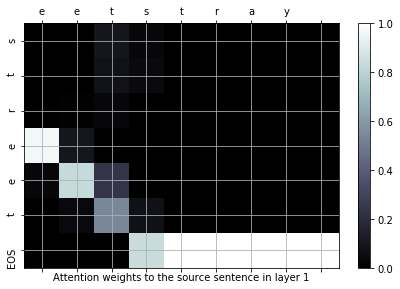

'eetstray'

In [0]:
TEST_WORD_ATTN = 'street'
visualize_attention(TEST_WORD_ATTN, rnn_attn_encoder, rnn_attn_decoder, None, args)

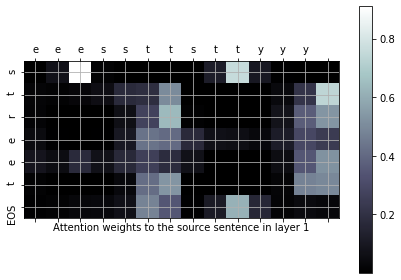

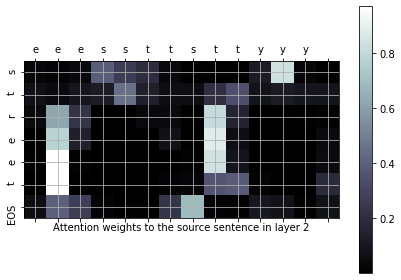

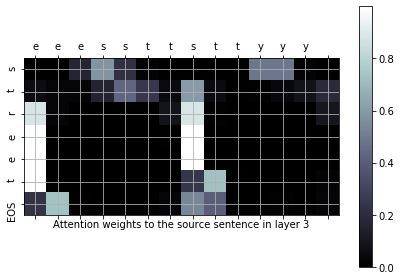

'eeessttsttyyy'

In [0]:
TEST_WORD_ATTN = 'street'
visualize_attention(TEST_WORD_ATTN, transformer_encoder, transformer_decoder, None, args, )